<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%203%20/%20Tugas%20/%20PyTorch_SVHN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load SVHN dataset
train_dataset = datasets.SVHN(root='./data', split='train', transform=transform, download=True)
test_dataset = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 182M/182M [00:07<00:00, 24.9MB/s]
100%|██████████| 64.3M/64.3M [00:02<00:00, 23.7MB/s]


In [ ]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP().to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
train_acc_list, test_acc_list, train_loss_list = [], [], []
for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    train_acc = correct / total
    train_loss = running_loss / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Evaluate on test set
    model.eval()
    correct, total = 0, 0
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    test_acc = correct / total
    test_acc_list.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch [1/10], Loss: 1.6310, Train Acc: 0.4416, Test Acc: 0.6190
Epoch [2/10], Loss: 1.2308, Train Acc: 0.6074, Test Acc: 0.6665
Epoch [3/10], Loss: 1.1281, Train Acc: 0.6444, Test Acc: 0.6838
Epoch [4/10], Loss: 1.0610, Train Acc: 0.6682, Test Acc: 0.6980
Epoch [5/10], Loss: 1.0186, Train Acc: 0.6843, Test Acc: 0.7178
Epoch [6/10], Loss: 0.9865, Train Acc: 0.6962, Test Acc: 0.7139
Epoch [7/10], Loss: 0.9584, Train Acc: 0.7054, Test Acc: 0.7148
Epoch [8/10], Loss: 0.9360, Train Acc: 0.7124, Test Acc: 0.7350
Epoch [9/10], Loss: 0.9194, Train Acc: 0.7186, Test Acc: 0.7448
Epoch [10/10], Loss: 0.8946, Train Acc: 0.7267, Test Acc: 0.7473


In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1_squared = f1_score(y_true, y_pred, average='macro') ** 2
auc = roc_auc_score(y_true, y_scores, multi_class='ovr')

print(f'Final Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Squared: {f1_squared:.4f}')
print(f'AUC: {auc:.4f}')

Final Accuracy: 0.7473
Precision: 0.7497
Recall: 0.7182
F1 Squared: 0.5334
AUC: 0.9529


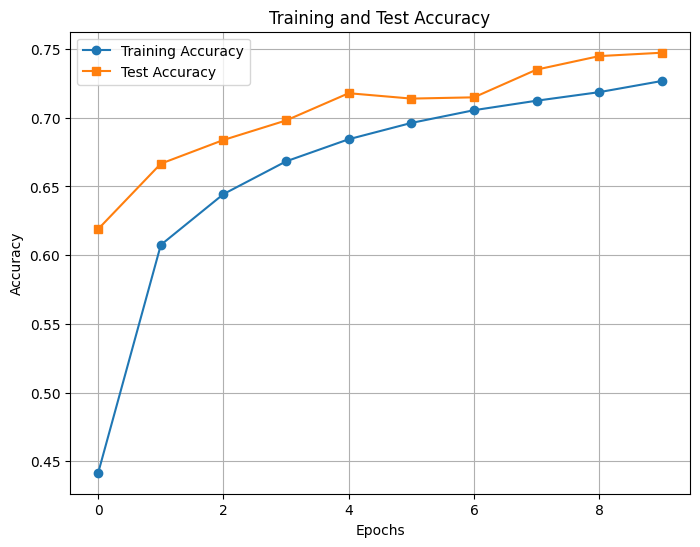

In [ ]:
# Plot training and testing accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list, label='Training Accuracy', marker='o')
plt.plot(test_acc_list, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid()
plt.show()

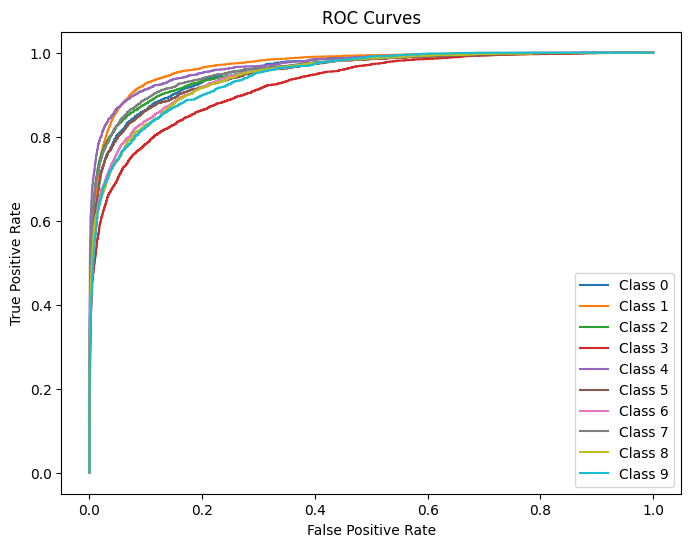

In [ ]:
# ROC Curve
plt.figure(figsize=(8, 6))
for i in range(10):
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_scores)[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Evaluasi Model CNN - CIFAR-10 Dataset

## Persamaan Matematika Evaluasi Model

Metrik evaluasi yang digunakan untuk menilai performa model CNN pada dataset CIFAR-10.

---

### 1. **Accuracy**

Mengukur seberapa banyak prediksi yang benar.


$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$


Keterangan:
- **TP** = True Positive
- **TN** = True Negative
- **FP** = False Positive
- **FN** = False Negative

---

### 2. **Precision**

Mengukur seberapa tepat prediksi positif model.

$\text{Precision} = \frac{TP}{TP + FP}$

---

### 3. **Recall**

Mengukur seberapa banyak data positif yang berhasil diprediksi model.

$\text{Recall} = \frac{TP}{TP + FN}$

---

### 4. **F1-Score**

Rata-rata harmonis dari Precision dan Recall untuk menyeimbangkan keduanya.

$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

---

### 5. **AUC (Area Under Curve)**

Mengukur kemampuan model untuk membedakan antara kelas positif dan negatif. Nilai AUC berada di antara 0 dan 1. Semakin tinggi nilainya, semakin baik model dalam membedakan antar kelas.

$$
\text{AUC} = \int_{0}^{1} \text{TPR}(\text{FPR}) \, d\text{FPR}
$$

---

### 6. **ROC Curve (Receiver Operating Characteristic Curve)**

Kurva ROC menggambarkan hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR):

\[
$\text{TPR} = \frac{TP}{TP + FN}$
\]

\[
$\text{FPR} = \frac{FP}{FP + TN}$
\]